<a href="https://colab.research.google.com/github/niazfh/CIND820/blob/main/EDA_vehicle_claim_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA — Vehicle Claim Fraud Detection

**Goal:** Exploratory data analysis for fraud triage modeling.  
**Dataset:** `fraud_oracle.csv` (Vehicle Claim Fraud Detection / Oracle dataset)  
**Target:** `FraudFound_P` (0 = non-fraud, 1 = fraud)

> Notes for project design:
> - This dataset is highly imbalanced (fraud is rare).
> - Some variables may be **post-claim / post-investigation** signals (potential leakage) and should be handled carefully depending on the decision point (FNOL vs later).


In [3]:
import pandas as pd, numpy as np

df = pd.read_csv("fraud_oracle.csv")
df.columns = [c.strip() for c in df.columns]
target = "FraudFound_P"

df.shape, df.columns.tolist()

((15420, 33),
 ['Month',
  'WeekOfMonth',
  'DayOfWeek',
  'Make',
  'AccidentArea',
  'DayOfWeekClaimed',
  'MonthClaimed',
  'WeekOfMonthClaimed',
  'Sex',
  'MaritalStatus',
  'Age',
  'Fault',
  'PolicyType',
  'VehicleCategory',
  'VehiclePrice',
  'FraudFound_P',
  'PolicyNumber',
  'RepNumber',
  'Deductible',
  'DriverRating',
  'Days_Policy_Accident',
  'Days_Policy_Claim',
  'PastNumberOfClaims',
  'AgeOfVehicle',
  'AgeOfPolicyHolder',
  'PoliceReportFiled',
  'WitnessPresent',
  'AgentType',
  'NumberOfSuppliments',
  'AddressChange_Claim',
  'NumberOfCars',
  'Year',
  'BasePolicy'])

In [4]:
# Quick overview
n_rows, n_cols = df.shape
missing = df.isna().sum().sum()
dup = df.duplicated().sum()
class_counts = df[target].value_counts().sort_index()
class_pct = (class_counts / n_rows * 100).round(2)

(n_rows, n_cols, missing, dup), pd.DataFrame({"count": class_counts, "pct": class_pct})

((15420, 33, np.int64(0), np.int64(0)),
               count    pct
 FraudFound_P              
 0             14497  94.01
 1               923   5.99)

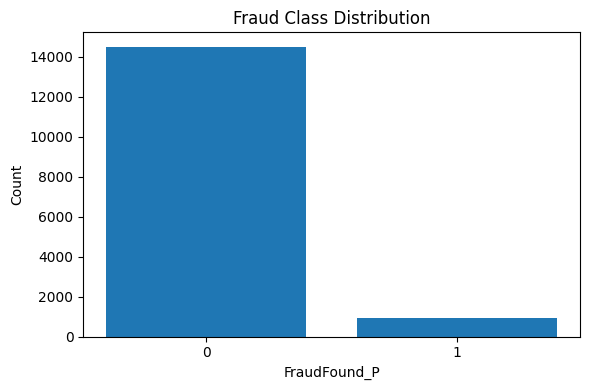

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
counts = df[target].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Fraud Class Distribution")
plt.xlabel(target)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [6]:
# Data types and basic feature split
num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != target]
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != target]

len(num_cols), num_cols, len(cat_cols)

(8,
 ['WeekOfMonth',
  'WeekOfMonthClaimed',
  'Age',
  'PolicyNumber',
  'RepNumber',
  'Deductible',
  'DriverRating',
  'Year'],
 24)

In [7]:
# Cardinality of categorical features (top 15)
card = pd.Series({c: df[c].nunique() for c in cat_cols}).sort_values(ascending=False)
card.head(15)

,0
Make,19
MonthClaimed,13
Month,12
PolicyType,9
AgeOfPolicyHolder,9
AgeOfVehicle,8
DayOfWeekClaimed,8
DayOfWeek,7
VehiclePrice,6
AddressChange_Claim,5


## Fraud rate by categorical features (top categories)

We compute fraud rate by category and visualize the highest-volume categories to spot patterns.


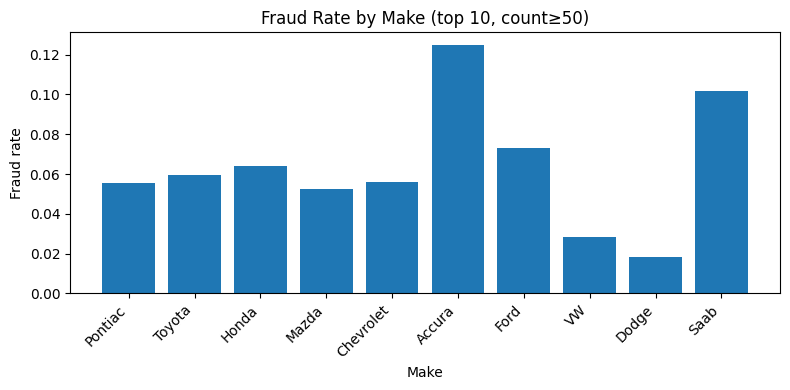

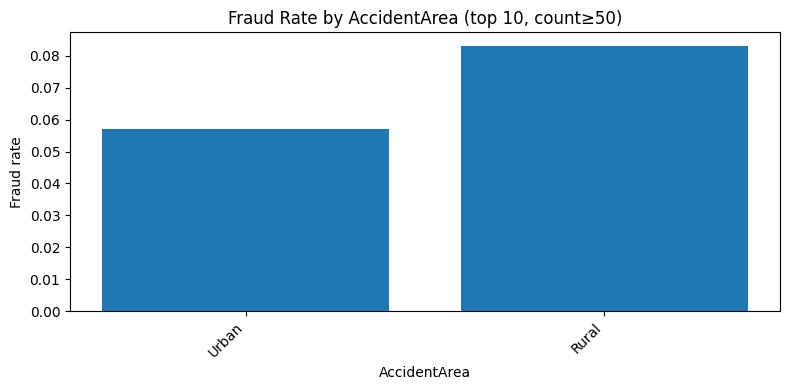

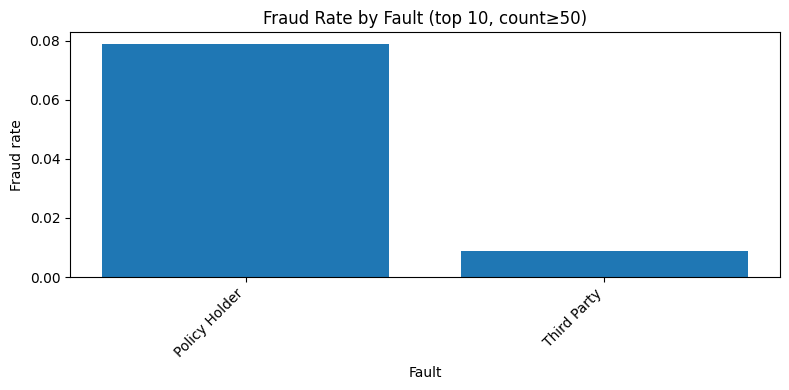

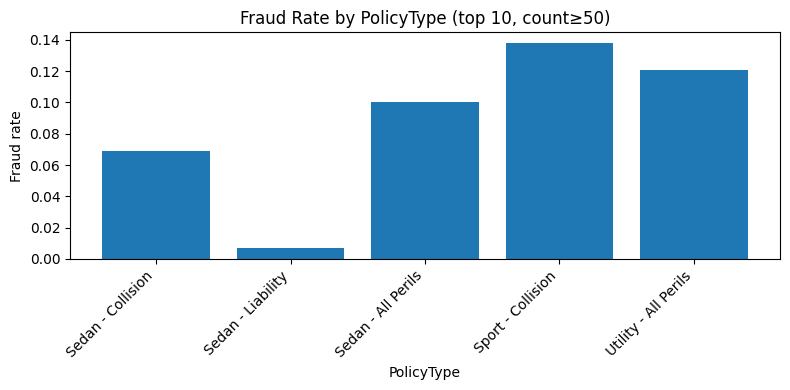

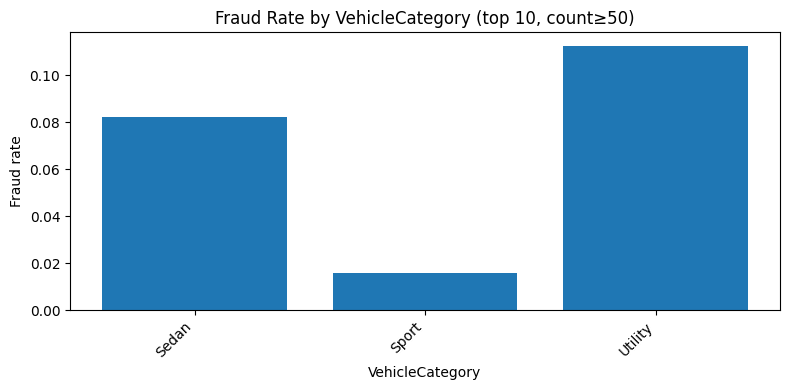

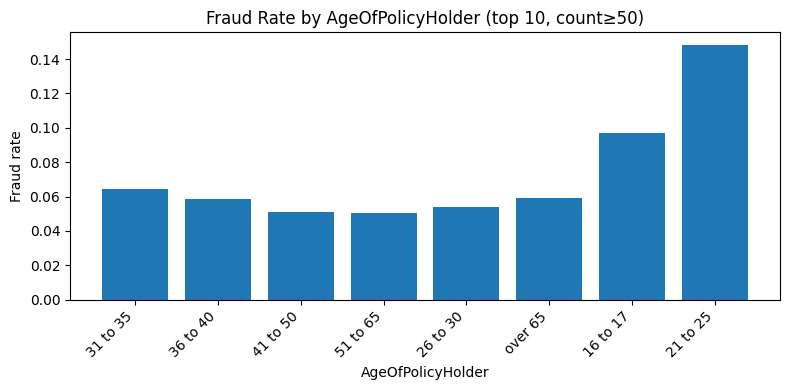

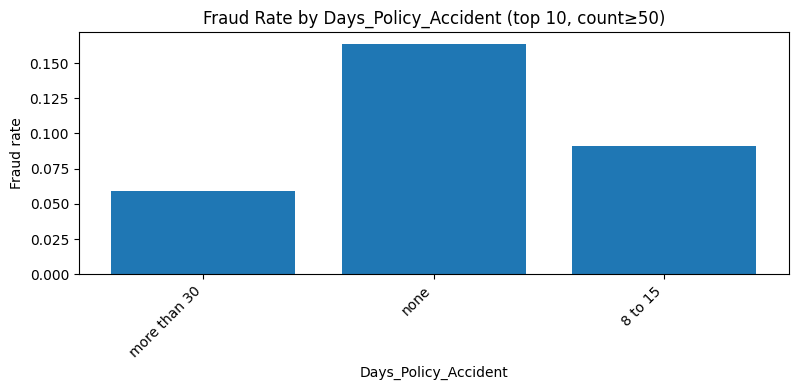

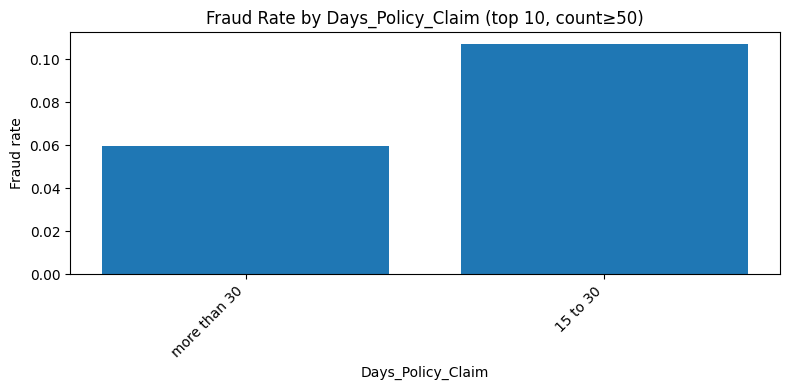

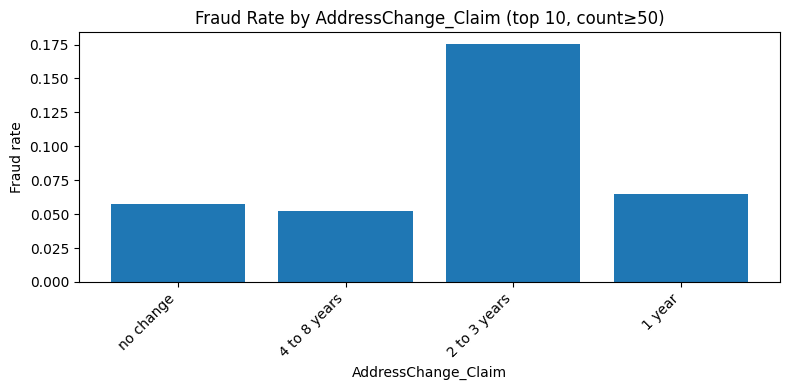

,count,mean
AgeOfPolicyHolder,,
31 to 35,5593,0.064366
36 to 40,4043,0.058620
41 to 50,2828,0.050919
51 to 65,1392,0.050287
26 to 30,613,0.053834
over 65,508,0.059055
16 to 17,320,0.096875
21 to 25,108,0.148148


In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

def plot_fraud_rate(feature, top_n=10, min_count=50):
    g = df.groupby(feature)[target].agg(['count','mean']).sort_values('count', ascending=False)
    g = g[g['count'] >= min_count].head(top_n)
    if g.empty:
        return
    plt.figure(figsize=(8,4))
    plt.bar(g.index.astype(str), g['mean'])
    plt.title(f"Fraud Rate by {feature} (top {top_n}, count≥{min_count})")
    plt.xlabel(feature)
    plt.ylabel("Fraud rate")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return g

# Choose a few high-signal / interpretable variables
tables = {}
for f in ["Make","AccidentArea","Fault","PolicyType","VehicleCategory","AgeOfPolicyHolder","Days_Policy_Accident","Days_Policy_Claim","AddressChange_Claim"]:
    t = plot_fraud_rate(f)
    tables[f] = t

tables["AgeOfPolicyHolder"].head(10) if tables.get("AgeOfPolicyHolder") is not None else None

## Numeric distributions

We inspect the distributions of the key numeric fields.  
`PolicyNumber` and `RepNumber` behave like identifiers and should not be used as predictive features.


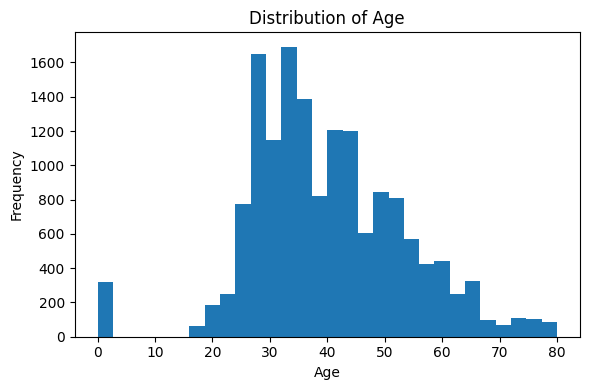

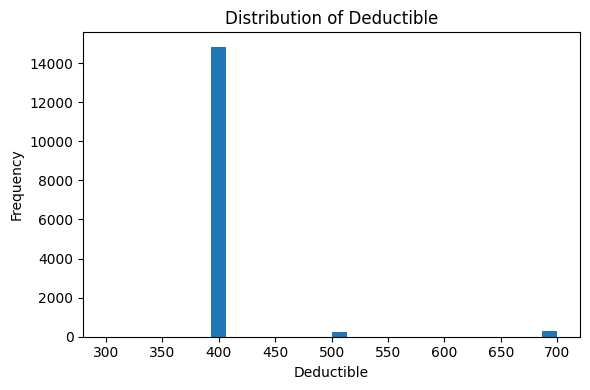

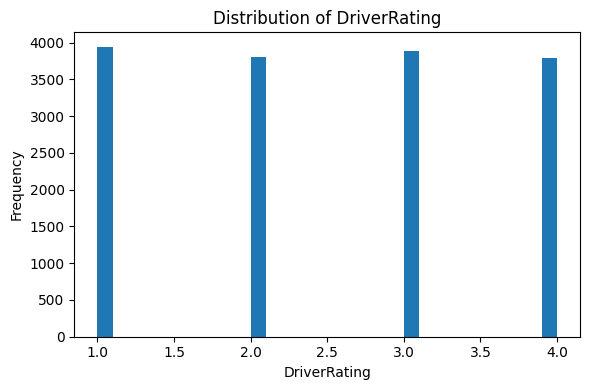

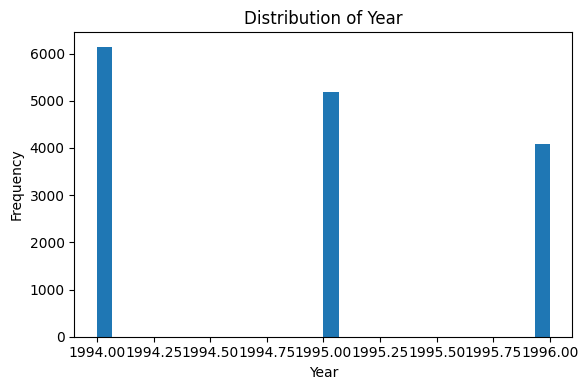

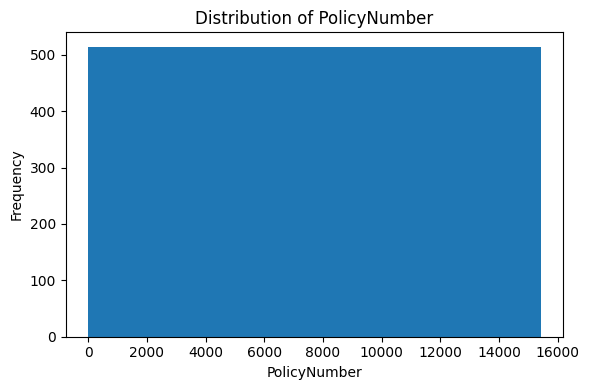

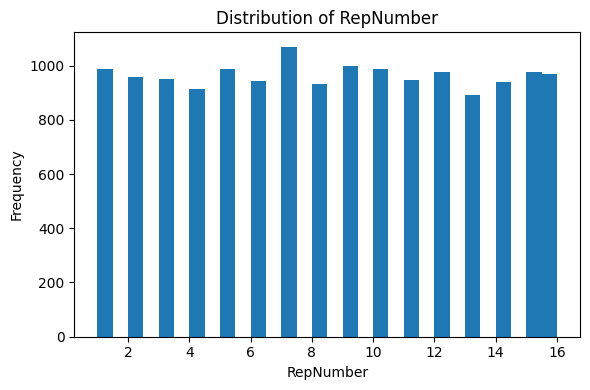

In [9]:
import matplotlib.pyplot as plt

for c in ["Age","Deductible","DriverRating","Year","PolicyNumber","RepNumber"]:
    if c not in df.columns:
        continue
    plt.figure(figsize=(6,4))
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## Potential leakage / decision-point fields


Common suspects in this dataset (verify with your interpretation):
- `NumberOfSuppliments` (supplemental claims often happen after initial filing)
- `PoliceReportFiled`, `WitnessPresent` (may be known at intake, but sometimes confirmed later)
- `RepNumber` (internal rep id), `PolicyNumber` (identifier)


In [10]:
# Quick look at a few suspect variables
suspects = ["NumberOfSuppliments","PoliceReportFiled","WitnessPresent","RepNumber","PolicyNumber"]
out = {}
for c in suspects:
    if c not in df.columns:
        continue
    if df[c].dtype == "object":
        out[c] = df.groupby(c)[target].agg(['count','mean']).sort_values('mean', ascending=False)
    else:
        out[c] = df[c].describe()
out

{'NumberOfSuppliments':                      count      mean
 NumberOfSuppliments                 
 none                  7047  0.066979
 1 to 2                2489  0.063881
 more than 5           3867  0.050427
 3 to 5                2017  0.048091,
 'PoliceReportFiled':                    count      mean
 PoliceReportFiled                 
 No                 14992  0.060499
 Yes                  428  0.037383,
 'WitnessPresent':                 count      mean
 WitnessPresent                 
 No              15333  0.060001
 Yes                87  0.034483,
 'RepNumber': count    15420.000000
 mean         8.483268
 std          4.599948
 min          1.000000
 25%          5.000000
 50%          8.000000
 75%         12.000000
 max         16.000000
 Name: RepNumber, dtype: float64,
 'PolicyNumber': count    15420.000000
 mean      7710.500000
 std       4451.514911
 min          1.000000
 25%       3855.750000
 50%       7710.500000
 75%      11565.250000
 max      15420.000000
